In [5]:
import pandas as pd
import numpy as np
import yfinance as yf

In [6]:
# Download SPY (S&P 500 ETF) data
spy = yf.download("SPY", start="2018-01-01")
spy.head()

C:\Users\christian-vs\AppData\Local\Temp\1\ipykernel_11132\807870434.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2018-01-02,237.909149,237.944564,236.696460,237.085941,86655700
2018-01-03,239.413956,239.564448,238.077329,238.077329,90070400
2018-01-04,240.423035,240.909898,239.475915,240.060136,80636400
2018-01-05,242.025253,242.149164,240.724041,241.219738,83524000
2018-01-08,242.467896,242.627221,241.635826,241.927923,57319200


## Calculate Daily Log Returns

In [7]:
# Use adjusted close prices - squeeze to get Series
prices = spy["Close"].squeeze()

# Calculate daily log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Create time series dataframe
ts = pd.DataFrame({"R": returns})
ts

,R
Date,
2018-01-03,0.006305
2018-01-04,0.004206
2018-01-05,0.006642
2018-01-08,0.001827
2018-01-09,0.002260
...,...
2025-11-28,0.005444
2025-12-01,-0.004576
2025-12-02,0.001851


## Visualize Returns Time Series

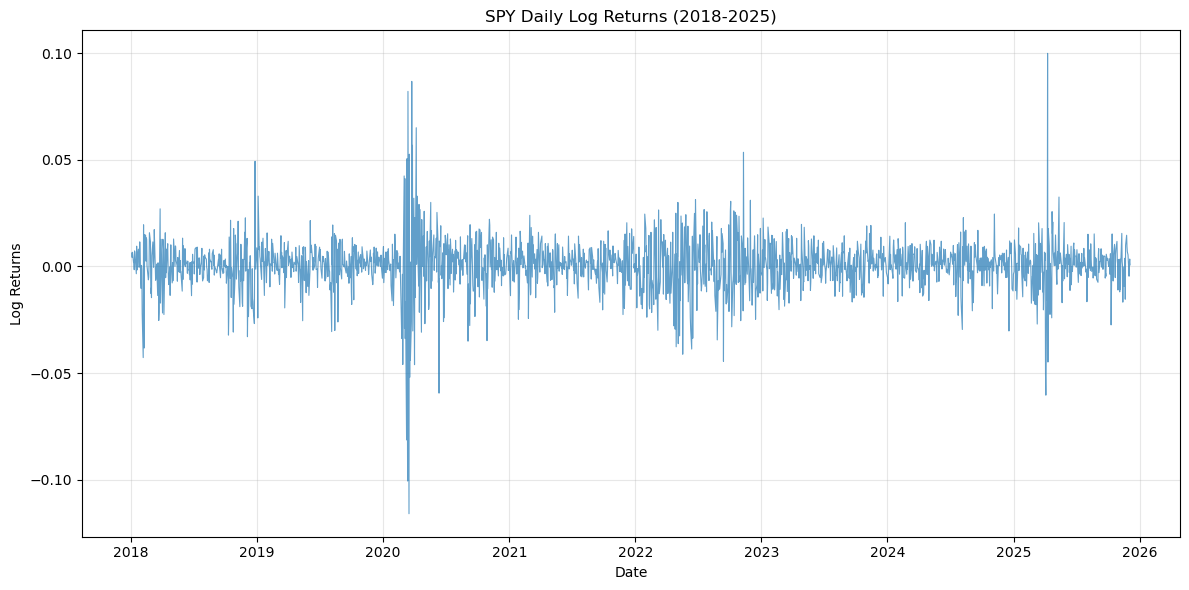

In [8]:
import matplotlib.pyplot as plt

# Plot returns over time
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts["R"], linewidth=0.8, alpha=0.7)
plt.title("SPY Daily Log Returns (2018-2025)")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## AR(1) Model - Autoregressive Model of Order 1

An AR(1) model assumes that today's return depends on yesterday's return plus random noise:

$$R_t = \phi_1 R_{t-1} + \epsilon_t$$

where $\epsilon_t \sim N(0, \sigma^2)$

### Intuition
- We model today's return as a linear function of yesterday's return
- If $\phi_1 > 0$: positive returns tend to follow positive returns (momentum)
- If $\phi_1 < 0$: positive returns tend to follow negative returns (mean reversion)
- The error term $\epsilon_t$ captures random shocks that cannot be predicted from past returns

In [9]:
import statsmodels.api as sm

# Fit AR(1) model (ARIMA with p=1, d=0, q=0)
ar1_model = sm.tsa.ARIMA(ts["R"], order=(1, 0, 0))
ar1_res = ar1_model.fit()

print("AR(1) Model Summary:")
print(ar1_res.summary())

# Extract parameters
phi1 = ar1_res.params.get("ar.L1", None)
sigma2_ar = ar1_res.params.get("sigma2", None)

print(f"\n{'='*50}")
print(f"φ₁ (AR coefficient) = {phi1:.4f}")
print(f"σ² (innovation variance) = {sigma2_ar:.6f}")
print(f"{'='*50}")

AR(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      R   No. Observations:                 1992
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5948.719
Date:                Fri, 05 Dec 2025   AIC                         -11891.437
Time:                        08:10:43   BIC                         -11874.646
Sample:                             0   HQIC                        -11885.271
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.119      0.034    3.96e-05       0.001
ar.L1         -0.1355      0.009    -14.507      0.000      -0.154      -0.117
sigma2         0.0001   1.85e-0

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## MA(1) Model - Moving Average Model of Order 1

An MA(1) model assumes that today's return depends on today's and yesterday's random shocks:

$$R_t = \epsilon_t + \theta_1 \epsilon_{t-1}$$

where $\epsilon_t \sim N(0, \sigma^2)$
### Intuition
- We model today's return as depending on today's random shock plus a weighted version of yesterday's shock
- If $\theta_1 > 0$: a positive shock yesterday increases today's expected return (positive shock persistence)
- If $\theta_1 < 0$: a positive shock yesterday decreases today's expected return (shock reversal)
- Unlike AR(1), MA(1) focuses on how past forecast errors (shocks) affect current values
- MA models are useful when returns show short-term dependencies in their innovations rather than in the returns themselves

In [10]:
# Fit MA(1) model (ARIMA with p=0, d=0, q=1)
ma1_model = sm.tsa.ARIMA(ts["R"], order=(0, 0, 1))
ma1_res = ma1_model.fit()

print("MA(1) Model Summary:")
print(ma1_res.summary())

# Extract parameters
theta1 = ma1_res.params.get("ma.L1", None)
sigma2_ma = ma1_res.params.get("sigma2", None)

print(f"\n{'='*50}")
print(f"θ₁ (MA coefficient) = {theta1:.4f}")
print(f"σ² (innovation variance) = {sigma2_ma:.6f}")
print(f"{'='*50}")

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MA(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      R   No. Observations:                 1992
Model:                 ARIMA(0, 0, 1)   Log Likelihood                5946.098
Date:                Fri, 05 Dec 2025   AIC                         -11886.197
Time:                        08:10:46   BIC                         -11869.406
Sample:                             0   HQIC                        -11880.030
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.082      0.037    3.08e-05       0.001
ma.L1         -0.1253      0.010    -12.368      0.000      -0.145      -0.105
sigma2         0.0001   1.84e-0

## Model Comparison Summary

In [11]:
# Create comparison table
summary = pd.DataFrame({
    "Model": ["AR(1)", "MA(1)"],
    "Coefficient": [phi1, theta1],
    "σ² (Innovation Variance)": [sigma2_ar, sigma2_ma],
    "AIC": [ar1_res.aic, ma1_res.aic],
    "BIC": [ar1_res.bic, ma1_res.bic]
})

summary

,Model,Coefficient,σ² (Innovation Variance),AIC,BIC
0,AR(1),-0.135538,0.000149,-11891.437032,-11874.646349
1,MA(1),-0.125284,0.000149,-11886.196869,-11869.406186


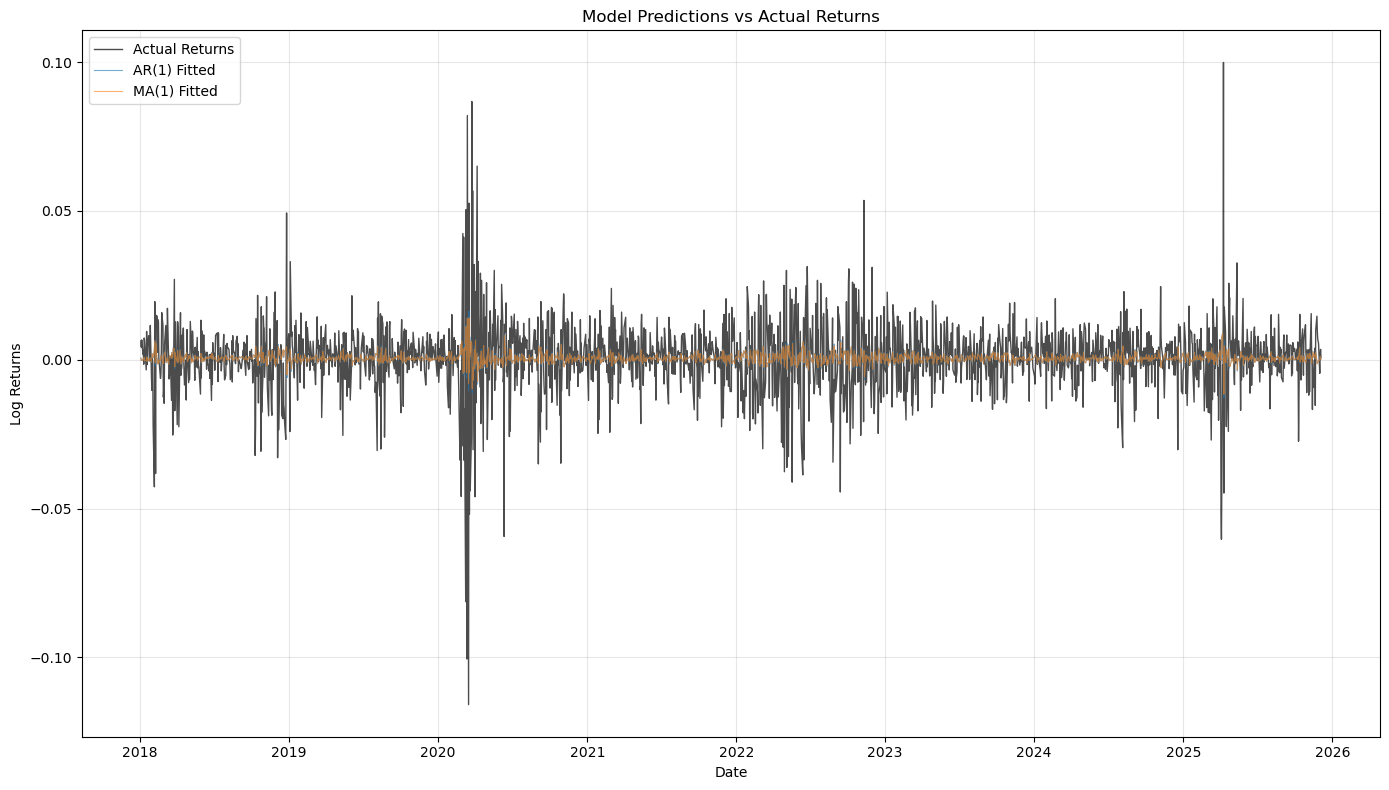

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prediction versus real data
# Get fitted values (in-sample predictions) from each model
ar1_fitted = ar1_res.fittedvalues
ma1_fitted = ma1_res.fittedvalues

# Plot actual vs predicted returns
plt.figure(figsize=(14, 8))

# Plot actual returns
plt.plot(ts.index, ts["R"], label='Actual Returns', color='black', linewidth=1, alpha=0.7)

# Plot fitted values from each model
plt.plot(ar1_fitted.index, ar1_fitted, label='AR(1) Fitted', linewidth=0.8, alpha=0.6)
plt.plot(ma1_fitted.index, ma1_fitted, label='MA(1) Fitted', linewidth=0.8, alpha=0.6)

plt.title('Model Predictions vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## ARIMA(p,d,q) - General Form

ARIMA combines:
- **AR(p)**: Autoregressive component (uses past values)
- **I(d)**: Integration/Differencing (makes series stationary)
- **MA(q)**: Moving average component (uses past errors)

General form: ARIMA(p,d,q)

$$\phi(B)(1-B)^d y_t = \theta(B)\epsilon_t$$

where:
- $\phi(B)$ is the AR polynomial
- $(1-B)^d$ is the differencing operator
- $\theta(B)$ is the MA polynomial
- $\epsilon_t$ is white noise

For stationary returns, d=0 is typical.

In [13]:
# Fit ARIMA(2,0,1) - combines AR(2) and MA(1)
arima_model = sm.tsa.ARIMA(ts["R"], order=(2, 0, 1))
arima_res = arima_model.fit()

print("ARIMA(2,0,1) Model Summary:")
print(arima_res.summary())

# Extract parameters
ar_coefs = [arima_res.params.get(f"ar.L{i}", None) for i in range(1, 3)]
ma_coef = arima_res.params.get("ma.L1", None)
sigma2_arima = arima_res.params.get("sigma2", None)

print(f"\n{'='*50}")
print(f"φ₁ (AR coefficient 1) = {ar_coefs[0]:.4f}")
print(f"φ₂ (AR coefficient 2) = {ar_coefs[1]:.4f}")
print(f"θ₁ (MA coefficient) = {ma_coef:.4f}")
print(f"σ² (innovation variance) = {sigma2_arima:.6f}")
print(f"{'='*50}")

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2,0,1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      R   No. Observations:                 1992
Model:                 ARIMA(2, 0, 1)   Log Likelihood                5954.174
Date:                Fri, 05 Dec 2025   AIC                         -11898.348
Time:                        08:11:17   BIC                         -11870.363
Sample:                             0   HQIC                        -11888.070
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.855      0.064   -2.99e-05       0.001
ar.L1         -0.1946      0.137     -1.420      0.156      -0.463       0.074
ar.L2          0.0646   